In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read Files

In [2]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [3]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [4]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [5]:
X_train_split_0, X_val, y_train_split_0, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split_0:", X_train_split_0.shape)
print("X_val:", X_val.shape)
print("y_train_split_0:", y_train_split_0.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split_0: (78197, 33)
X_val: (33514, 33)
y_train_split_0: (78197,)
y_val: (33514,)


In [6]:
Y1= pd.concat([X_train_split_0, y_train_split_0], axis=1)

In [7]:
Y1

,EverAtLeast1DPD_3mos,EverAtLeast15DPD_3mos,EverAtLeast31DPD_3mos,EverAtLeast61DPD_3mos,EverAtLeast1DPD_6mos,EverAtLeast15DPD_6mos,EverAtLeast31DPD_6mos,EverAtLeast61DPD_6mos,EverAtLeast1DPD_9mos,EverAtLeast15DPD_9mos,...,Missed_past6mos,Partial_past6mos,Full_past6mos,Missed_past9mos,Partial_past9mos,Full_past9mos,Missed_past12mos,Partial_past12mos,Full_past12mos,DEFAULT_TAGGING
11757,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
39534,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
9963,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
72838,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
40217,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,2,0,10,0
24028,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
36067,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,2,0,10,0
24985,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,3,0,9,0


In [8]:
# Define X1 (features) and y1 (target)
X_1 = Y1.drop(columns=["DEFAULT_TAGGING"])  
Y_1 = Y1["DEFAULT_TAGGING"].astype(int)  # Convert target to integer Series

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# import numpy as np
# import pandas as pd

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
X1_resampled, Y1_resampled = undersampler.fit_resample(X_1, Y_1)

# Convert back to DataFrame
x1_resampled = pd.DataFrame(X1_resampled, columns=X_1.columns)
y1_resampled = pd.Series(Y1_resampled, name="DEFAULT_TAGGING")

# Print class distribution
print("Before undersampling:", Counter(Y_1))
print("After undersampling:", Counter(y1_resampled))


Before undersampling: Counter({0: 77699, 1: 498})
After undersampling: Counter({0: 2490, 1: 498})


In [10]:
Y1_resampled = pd.concat([x1_resampled, y1_resampled], axis=1)

# Check if rows are still aligned properly
print(Y1_resampled.tail())  # Preview first few rows

       EverAtLeast1DPD_3mos  EverAtLeast15DPD_3mos  EverAtLeast31DPD_3mos  \
9751                      1                      1                      1   
32933                     1                      1                      0   
64531                     1                      1                      1   
78107                     0                      0                      0   
7117                      1                      1                      1   

       EverAtLeast61DPD_3mos  EverAtLeast1DPD_6mos  EverAtLeast15DPD_6mos  \
9751                       1                     1                      1   
32933                      0                     1                      1   
64531                      1                     1                      1   
78107                      0                     0                      0   
7117                       1                     1                      1   

       EverAtLeast31DPD_6mos  EverAtLeast61DPD_6mos  EverAtLeast1DPD_9mos 

In [11]:
xvars = [
    'EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos', 'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 'Partial_past3mos', 'Full_past3mos', 'Missed_past6mos', 'Partial_past6mos', 
    'Full_past6mos', 'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 'Full_past12mos'
]
    
yvar = 'DEFAULT_TAGGING'  # Target variable for y1

# Prepare training data (y1)
X_train_split = Y1_resampled[xvars]
y_train_split = Y1_resampled[yvar]

#### Option 1 Grid Search 

In [12]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity
#change param_grid based on your chosen range of values
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):
    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }






    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Threshold tuning based on maximum F1 score
        precision, recall_arr, thresholds = precision_recall_curve(y_val, y_proba[:, 1])
        f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
        optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    # Print final best results
    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results

In [13]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7837
 → Recall: 0.7277, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9153
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9587
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9661
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9259
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9699
 → Recall: 0.7653, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9923
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9947
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9565
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 45
True Positives (TP): 168
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9770
 → Recall: 0.7887, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9937
 → Recall: 0.7793, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9974
 → Recall: 0.7746, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9662
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9952
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9985
 → Recall: 0.7653, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9993
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9833
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9989
 → Recall: 0.7512, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9992
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9998
 → Recall: 0.7512, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7875
 → Recall: 0.7230, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9179
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9513
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9687
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9132
 → Recall: 0.7653, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9764
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9930
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9960
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9622
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9920
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9967
 → Recall: 0.7793, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9996
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9761
 → Recall: 0.7606, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9933
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9987
 → Recall: 0.7746, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33275
False Positives (FP): 26
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9997
 → Recall: 0.7700, Specificity: 0.9992

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanc

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9866
 → Recall: 0.7746, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9980
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9998
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33280
False Positives (FP): 21
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7875
 → Recall: 0.7230, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9239
 → Recall: 0.7606, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9628
 → Recall: 0.7653, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9768
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Neil\AppData\Local\Temp\ipykernel_22584\1605550589.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 213
True Positives (TP): 0
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9620
 → Recall: 0.0000, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9890
 → Recall: 0.7793, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9961
 → Recall: 0.7840, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9237
 → Recall: 0.7981, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9917
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9968
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9761
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9979
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9997
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown paramete

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9872
 → Recall: 0.7746, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9989
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7875
 → Recall: 0.7230, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9239
 → Recall: 0.7606, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9628
 → Recall: 0.7653, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9779
 → Recall: 0.7653, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Neil\AppData\Local\Temp\ipykernel_22584\1605550589.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 213
True Positives (TP): 0
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9620
 → Recall: 0.0000, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9871
 → Recall: 0.7840, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=80, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9955
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFrom

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9237
 → Recall: 0.7981, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9939
 → Recall: 0.7606, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9734
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9984
 → Recall: 0.7559, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positiv

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9870
 → Recall: 0.7700, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9992
 → Recall: 0.7606, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.7875
 → Recall: 0.7230, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9239
 → Recall: 0.7606, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start train

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Neil\AppData\Local\Temp\ipykernel_22584\1605550589.py:59: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 213
True Positives (TP): 0
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9620
 → Recall: 0.0000, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=100, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9871
 → Recall: 0.7840, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9237
 → Recall: 0.7981, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9924
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positi

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9734
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9984
 → Recall: 0.7559, Specificity: 0.9996

[LightGBM] [Warning] Unknown paramet

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9870
 → Recall: 0.7700, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## LGBM MODEL

In [14]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.09,
    num_iterations=50,
    num_leaves=60,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)

#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 2490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 2988, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Model Training Complete


## Option 1: Optimal Threshold using Precision-Recall Curve

In [15]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal threshold for maximum F1 score:", optimal_threshold)

Optimal threshold for maximum F1 score: 0.9236521645988399


## Apply Optimal Threshold

In [17]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [18]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
[[33278    23]
 [   43   170]]
Accuracy: 0.9980
Precision: 0.8808
Recall: 0.7981
F1 Score: 0.8374
AUC: 0.9858
Specificity: 0.9993


## SHAP Plots

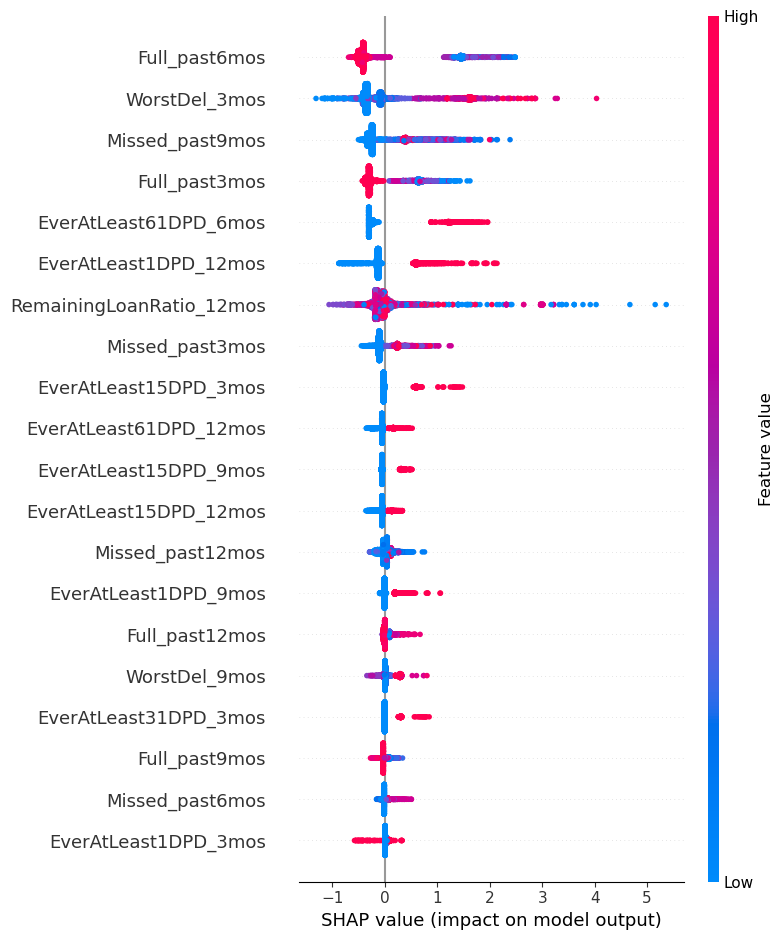

In [19]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

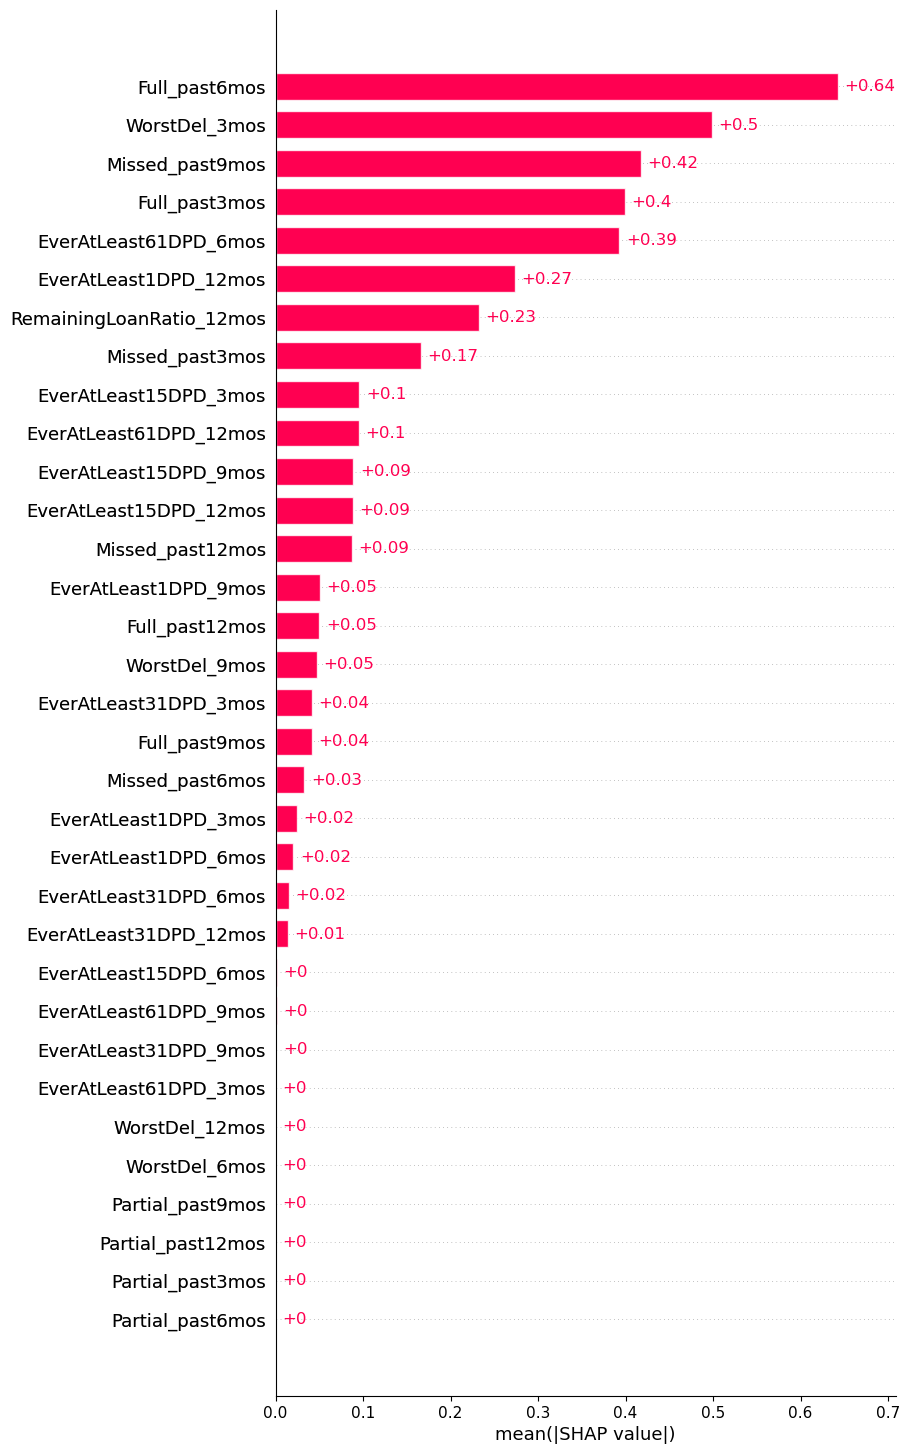

In [20]:
shap.plots.bar(shap_values, max_display=50)